In [7]:
import pickle
fn = '/DeepPostures_MAE/MoCA/hip_misclassified.pkl'

with open(fn, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
print(len(data['series']), len(data['true_labels']))

dict_keys(['series', 'true_labels', 'pred_labels'])
5011 5011


In [8]:
# conver data['series'] from list to numpy array
import numpy as np
data['series'] = np.array(data['series'])
print(data['series'].shape)

(5011, 100, 3)


In [74]:

sample_idx = 100

def plot_samples(data, sample_idx):
    label_map = {0: 'sitting', 1:'non-sitting'}
    plot_samples = data['series'][sample_idx] # 100,3
    gt = data['true_labels'][sample_idx]
    pred_label = data['pred_labels'][sample_idx]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    # plot in the y-scale of -1,1
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(plot_samples[:, i])
        plt.title(f'Channel {i+1}')
        plt.xlabel('Time')
        plt.ylim(-1.5, 1.5)
        #plt.ylabel('Position')

    print(f'GT: {label_map[gt]}, Pred: {label_map[pred_label]}')


index: 323
GT: sitting, Pred: non-sitting


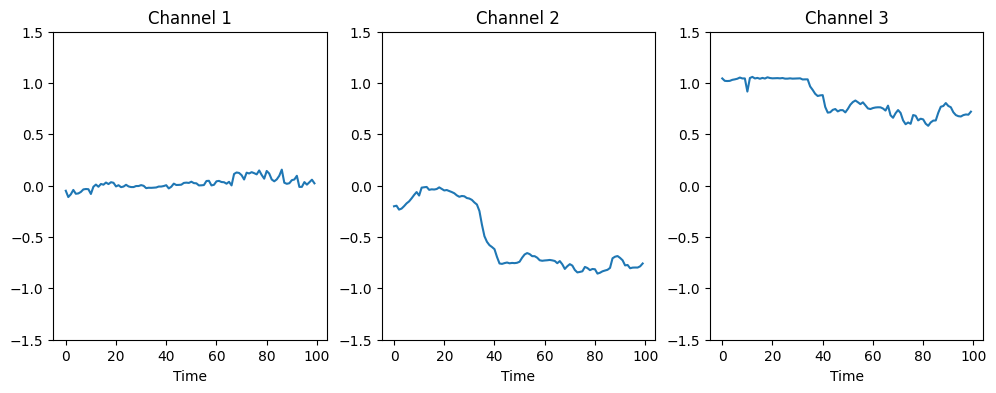

In [78]:
#select random index from 0 to 5010
import random
sample_idx = random.randint(0, 5010)
print('index:', sample_idx)
plot_samples(data, sample_idx)

In [41]:
from models_mae import MaskedAutoencoderViT
from functools import partial
import torch.nn as nn
import torch


model = MaskedAutoencoderViT(img_size=[3,100],patch_size=[1,5],
                                in_chans=1,embed_dim=768, depth=12, num_heads=12,
                                decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                                mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6),)

model_weight = '/niddk-data-central/leo_workspace/MoCA_result/ckpt/iWatch-Hipps_5_mask_0.75_bs_512_blr_None_epoch_50/2025-05-05_01-23/checkpoint-49.pth'

checkpoint = torch.load(model_weight, map_location='cpu')['model']
msg = model.load_state_dict(checkpoint, strict=True)
print(msg)

<All keys matched successfully>


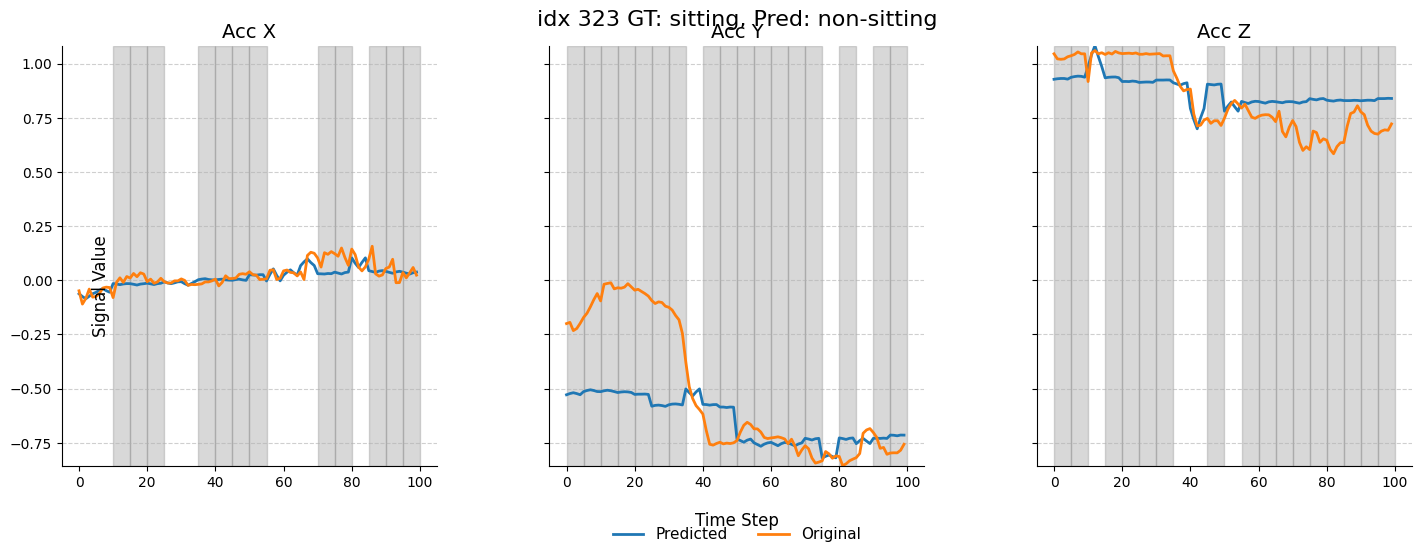

In [79]:

from engine_pretrain import train_one_epoch, plot_masked_series
idx = 323
tmp_sample = torch.from_numpy(data['series'][idx]).permute(1,0).unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    tmp_loss, tmp_pred, tmp_mask = model(tmp_sample, mask_ratio=0.75,masking_scheme = 'random')
tmp_pred = model.unpatchify(tmp_pred)
tmp_mask = tmp_mask.reshape(shape=(3,20))
fig = plot_masked_series(
    tmp_mask,
    tmp_pred,
    tmp_sample,
    title=f'idx {idx} GT: {label_map[data["true_labels"][idx]]}, Pred: {label_map[data["pred_labels"][idx]]}'
)